<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/05_Transfer_learning_in_tensorflow_part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ of pre-trained model.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)

## What we're going to cover

We're going to go through the follow with TensorFlow:
- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data.
- Using the Keras Functional API (a different way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data:
  - Model 0: a transfer learning model using Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2 : a feature extraction transfer learning model on 10 % of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard

In [1]:
# Using a GPU?
!nvidia-smi

Sun Oct  9 10:10:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

Throughout your machine learning experiments, you'll likely come accross snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again. But as you might have guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper functions script such as `helper_functions.py`. And then import the necessary functionality when you need it.


Let's see what this looks like.

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py 

--2022-10-09 10:10:27--  https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2631 (2.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.57K  --.-KB/s    in 0s      

2022-10-09 10:10:27 (53.9 MB/s) - ‘helper_functions.py’ saved [2631/2631]



In [3]:
# import Helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

## 1O Food Classes: Working with less data

We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the `tf.keras.applications` module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, `image_dataset_from_directory()` which is part of the `tf.keras.preprocessing` module.

Finally, we'll also be practicing using the [`Keras Functional API`](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

In [4]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-10-09 10:10:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 74.125.200.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2022-10-09 10:10:31 (165 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# unzip the data
unzip_data("/content/10_food_classes_10_percent.zip")

In [6]:
# walkthrough the directories
walk_through_dir("/content/10_food_classes_10_percent")

/content/10_food_classes_10_percent: There are 2 directories and 0 files
/content/10_food_classes_10_percent/test: There are 10 directories and 0 files
/content/10_food_classes_10_percent/test/chicken_wings: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/steak: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/hamburger: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/fried_rice: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/ice_cream: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/chicken_curry: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/ramen: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/sushi: There are 0 directories and 250 files
/content/10_food_classes_10_percent/test/grilled_salmon: There are 0 directories and 250 files
/content/10_food_classes_10_percent/

In [7]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously we've used the `ImageDataGenerator` class. And while this works well and is still very commonly used, this time we're going to use the `image_data_from_directory` function.

It works much the same way as `ImageDataGenerator`'s `flow_from_directory` method meaning your images need to be in the following file format:

Example of file structure:
10_food_classes_10_percent <- top level folder
└───train <- training images 
│   │   │     
│   └───pizza
    
│- - - - -  1008104.jpg'

│- - - - -  1638227.jpg
 
│- - - - -  ...      
│   └───steak

│- - - - -  1000205.jpg

│- - - - -  1647351.jpg

│- - - - -   ...
      
└───test <- testing images

│   └───pizza

│- - - - -  1001116.jpg

│- - - - -  1507019.jpg

│- - - - -  ...      

│   └───steak

│- - - - -  100274.jpg

│- - - - -  1653815.jpg

│- - - - -  ...   

One of the main benefits of using `tf.keras.preprocessing.image_dataset_from_directory()` rather than `ImageDataGenerator` is that it creates a `tf.data.Dataset` object rather than a generator. The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.



In [8]:
# Create data inputs

import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=BATCH_SIZE) # batch_size is 32 by default, this is generally a good number

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)                                                                         

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


It looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory()` function are:
- `directory` - the filepath of the target directory we're loading images in from.
- `image_size` - the target size of the images we're going to load in (height, width).
- `batch_size` - the batch size of the images we're going to load in. For example if the batch_size is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

In [9]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:
- `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channel (red, green blue).
- `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
- Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using `tf.data.Dataset` API are the associated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [10]:
# get the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of batch of data
train_data_10_percent.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [12]:
for images, labels in train_data_10_percent.take(1):
  print(images)
  print(labels)

tf.Tensor(
[[[[1.82071426e+02 1.48071426e+02 8.70714340e+01]
   [1.77668365e+02 1.45668365e+02 8.66683655e+01]
   [1.78857132e+02 1.48285706e+02 9.15000076e+01]
   ...
   [1.88852173e+02 1.58852173e+02 1.04852180e+02]
   [2.02714371e+02 1.73714371e+02 1.17714378e+02]
   [2.17357315e+02 1.88357315e+02 1.32357315e+02]]

  [[1.81566315e+02 1.46566315e+02 9.04234695e+01]
   [1.76933670e+02 1.44933670e+02 8.79336700e+01]
   [1.79673462e+02 1.49102036e+02 9.38877563e+01]
   ...
   [1.94040894e+02 1.64683685e+02 1.12357162e+02]
   [1.95153076e+02 1.65153076e+02 1.11153076e+02]
   [1.98362244e+02 1.68362244e+02 1.14362251e+02]]

  [[1.78714279e+02 1.43500000e+02 8.99285736e+01]
   [1.77500000e+02 1.44500000e+02 9.18418350e+01]
   [1.76045929e+02 1.44474487e+02 9.36887741e+01]
   ...
   [1.90045959e+02 1.60306107e+02 1.10903061e+02]
   [1.93556152e+02 1.63556152e+02 1.13443878e+02]
   [1.95709183e+02 1.65709183e+02 1.14137749e+02]]

  ...

  [[1.65285751e+02 1.72928543e+02 1.39500015e+02]
   [1

Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` for `hamburger`)

## Model 0: Building a transfer learning model using the Keras Functional API

Let's build a model.

To do so we're going to be using the `tf.keras.applications` module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as `EfficientNetB0` from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1.
> **Note :** As of writing, the `EfficientNetB0` models in `tf.keras.applications` module do not require images to be normalized on input, where as many of the other models do. 

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using `tf.keras.layers.GlobalAveragePooling2D()` or `tf.keras.layers.GlobalMaxPooling2D()` though the former is more common in practice).
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using `tf.keras.Model()`
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks.

In [13]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name='inputLayer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs 
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="outputLayer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [14]:
# Compile our model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [15]:
# fit our model
history_model0 = model_0.fit(train_data_10_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data_10_percent,
                             validation_steps=int(0.25*len(test_data_10_percent)), # validate on only 25% of test_data (validate quicker)
                             callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extract")])

Saving TensorBoard log files to :transfer_learning/10_percent_feature_extract/2022-10-09_10:10:45
Epoch 1/5
24/24 [==============================] - 20s 219ms/step - loss: 1.8037 - accuracy: 0.4560 - val_loss: 1.2724 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 4s 146ms/step - loss: 1.0988 - accuracy: 0.7520 - val_loss: 0.9275 - val_accuracy: 0.7895
Epoch 3/5
24/24 [==============================] - 5s 184ms/step - loss: 0.8166 - accuracy: 0.7880 - val_loss: 0.7510 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 5s 184ms/step - loss: 0.6765 - accuracy: 0.8373 - val_loss: 0.6733 - val_accuracy: 0.8224
Epoch 5/5
24/24 [==============================] - 5s 184ms/step - loss: 0.5742 - accuracy: 0.8640 - val_loss: 0.6242 - val_accuracy: 0.8306


In [16]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 85ms/step - loss: 0.5998 - accuracy: 0.8452


[0.5998407006263733, 0.8452000021934509]

After a minute or so of training our model performs incredibly well on the training and test sets. 

It's important to note the kind of transfer learning we used here is called **feature extraction** transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetB0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

In [17]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [18]:
# summary of the base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [19]:
# summary of the model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 outputLayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Our overall model has five layers but really, one of those layers (`EfficientNetB0`) has 236 layers.

You can see how the output shape started out as `(None,224,224,3)` for the input layer but was transformed to be `(None, 10)` by the output layer, where None is the placeholder for the batch size.

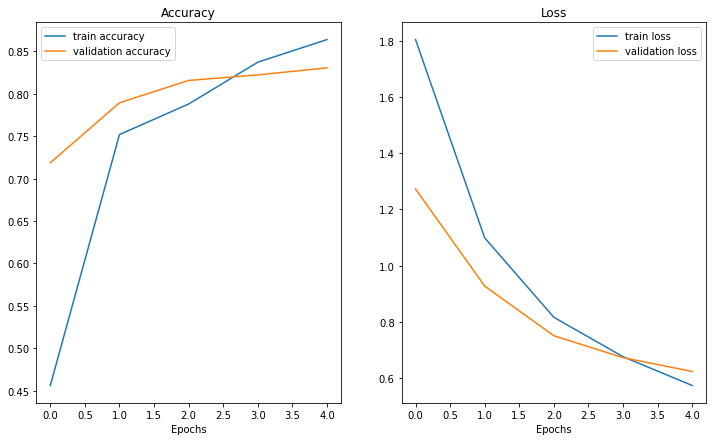

In [20]:
# Check out our model's training curves
plot_loss_curves(history_model0)

## Getting a feature vector from a trained model

The `tf.keras.layers.GlobalAveragePooling2D()` layer transforms a 4D tensor into a 2D tensor by averaging the value across the inner-axes.

Let's see an example.

In [21]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Shape of the random tensor: {input_tensor.shape}")
print(f"Random input_tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape of the global average pooled random tensor: {global_average_pooled_tensor.shape}")
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}")


Shape of the random tensor: (1, 4, 4, 3)
Random input_tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Shape of the global average pooled random tensor: (1, 3)
2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]


We can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed  the input tensor from shape `(1,4,4,3)` to `(1,3)`. It did so by averaging the `input_tensor` accross the middle axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifyind the appropriate axes.

In [22]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [23]:
# Example with GlobalMaxPool2D
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"Global max pooled tensor:\n {global_max_pooled_tensor}\n")

# Replicate the GlobalMaxPool2D layer with tf.reduce_max
reduce_max_tensor = tf.reduce_max(input_tensor, axis=[1,2])
print(f"Reduce max pooled tensor:\n {reduce_max_tensor}")

Global max pooled tensor:
 [[0.9058464 1.1603122 1.6994323]]

Reduce max pooled tensor:
 [[0.9058464 1.1603122 1.6994323]]


Doing this not only makes the ouput of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense())`, it also condenses the information found by the base model into a lower dimension **feature vector**.

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data ?

What kind of results do you think we can get using 100x less data than the original CNN models we build ourselves?

Why don't we answer that question while running the following modelling experiments:

1. `model_1`: USe feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the `tf.keras.layers.experimental.preprocessing` module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

### Download and preprocessed data for model 1

In [24]:
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-10-09 10:11:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  72.7MB/s    in 1.8s    

2022-10-09 10:11:40 (72.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [25]:
# unzip data
unzip_data("10_food_classes_1_percent.zip")

In [26]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [27]:
# walkthroug the data
walk_through_dir("10_food_classes_1_percent")

10_food_classes_1_percent: There are 2 directories and 0 files
10_food_classes_1_percent/test: There are 10 directories and 0 files
10_food_classes_1_percent/test/chicken_wings: There are 0 directories and 250 files
10_food_classes_1_percent/test/steak: There are 0 directories and 250 files
10_food_classes_1_percent/test/hamburger: There are 0 directories and 250 files
10_food_classes_1_percent/test/fried_rice: There are 0 directories and 250 files
10_food_classes_1_percent/test/ice_cream: There are 0 directories and 250 files
10_food_classes_1_percent/test/chicken_curry: There are 0 directories and 250 files
10_food_classes_1_percent/test/ramen: There are 0 directories and 250 files
10_food_classes_1_percent/test/sushi: There are 0 directories and 250 files
10_food_classes_1_percent/test/grilled_salmon: There are 0 directories and 250 files
10_food_classes_1_percent/test/pizza: There are 0 directories and 250 files
10_food_classes_1_percent/train: There are 10 directories and 0 files


Time to load our images in as `tf.data.Dataset` objects, to do so, we'll use the `image_dataset_from_directory()` method.

In [28]:
# Setup data loaders
IMG_SIZE = (224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How ?

Using the `tf.keras.layers.experimental.preprocessing` module and creating a dedicated data augmentation layer.

This is a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

- Preprocessing of the images (augmenting them) happens on the GPU rather on the CPU (much faster).
  - Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
- Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)

>🤔 Note: At the time of writing, the preprocessing layers we're using for data augmentation are in experimental status within the in TensorFlow library. This means although the layers should be considered stable, the code may change slightly in a future version of TensorFlow. For more information on the other preprocessing layers avaiable and the different methods of data augmentation, check out the [Keras preprocessing layers guide](https://keras.io/guides/preprocessing_layers/) and the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

The data augmentation transformations we're going to use are:
- **RandomFlip** - flips image on horizontal or vertical axis.
- **RandomRotation** - randomly rotates image by a specified amount.
- **RandomZoom** - randomly zooms into an image by specified amount.
- **RandomHeight** - randomly shifts image height by a specified amount.
- **RandomWidth** - randomly shifts image width by a specified amount.
- **Rescaling** - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the `tf.keras.applications` implementation of `EfficientNetB0`, it's not required.


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers. experimental import preprocessing

In [30]:
# create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.)  # keep for models like ResNet50V2, remove for EfficientNetB0
], name="data_augmentation")

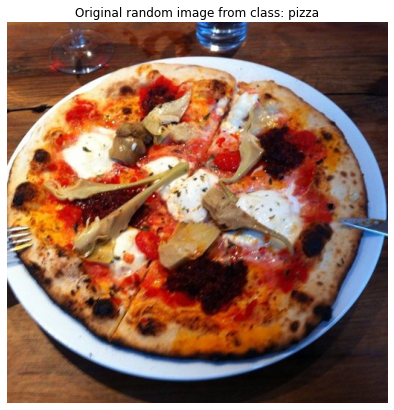

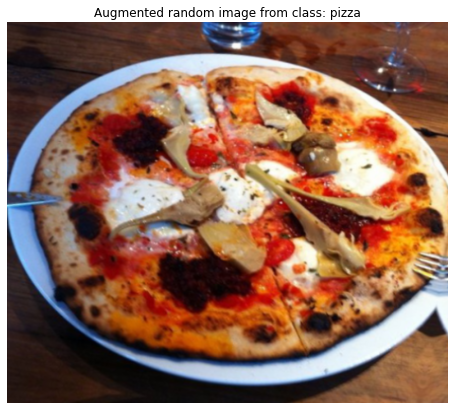

In [31]:
# view a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# read in the random image
img = mpimg.imread(random_image_path)

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)
plt.show()

# augment the image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0), training=True)
plt.figure(figsize=(10,7))
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.show()

Because we're going to add the data augmentation model as a layer in our upcoming transfer learning mdoel, it'll apply these kind of random augmentations to each of the training images which passes through it.

Doing this will make our training dataset a little more varied. You can think of it as if you ware taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

## Model 1: Feature extraction transfer learning on 1% of the data augmentation

In [32]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Creating input layer
inputs = layers.Input(shape=input_shape,
                      name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs after augmentation and don't train it
x = base_model(x, training=False)

# Pool ouput features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(len(train_data_1_percent.class_names), activation="softmax", name="ouput_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

In [33]:
# compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
# fit the model
history_model_1 = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to :transfer_learning/1_percent_data_aug/2022-10-09_10:11:45
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.3855 - accuracy: 0.0857 - val_loss: 2.2274 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1655 - accuracy: 0.2429 - val_loss: 2.0978 - val_accuracy: 0.2648
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9856 - accuracy: 0.3571 - val_loss: 1.9995 - val_accuracy: 0.3470
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8113 - accuracy: 0.5000 - val_loss: 1.9044 - val_accuracy: 0.4145
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6076 - accuracy: 0.6857 - val_loss: 1.8203 - val_accuracy: 0.4539


Using only 7 training images per class, using transfer learning our model was able to get ~45% accuracy on the validation set. This result is pretty amazing since the [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) achieved 50.67% accuracy with all the data, namely, 750 training images per class.

In [35]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

We've now got data augmentation built right into our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is **data augmentation only runs during training**. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.

In [36]:
# Evaluate on the test data
model_1.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 1.8047 - accuracy: 0.4672


[1.8046932220458984, 0.46720001101493835]

The results here may be slightly better/worse than the log outputs of our model during training because during training we only evaluate our model on 25% of the test data using the line `validation_steps=int(0.25 * len(test_data))`. Doing this speeds up our epochs but still gives us enough of an idea of how our model is going.

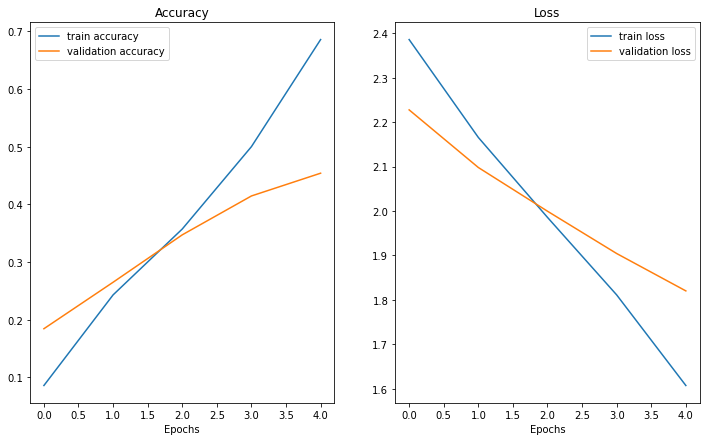

In [37]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_model_1)

It looks like the metrics on both datasets would improve if we kept training for more epochs. But we'll leave that for now, we've got more experiments to do!

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

We've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

> **Question**: How do you know what experiments to run?

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow yout curiosity as tenaciously as possible. if you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [38]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

In [41]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [43]:
# How many images in our directory?
walk_through_dir(train_dir_10_percent)

10_food_classes_10_percent/train/: There are 10 directories and 0 files
10_food_classes_10_percent/train/chicken_wings: There are 0 directories and 75 files
10_food_classes_10_percent/train/steak: There are 0 directories and 75 files
10_food_classes_10_percent/train/hamburger: There are 0 directories and 75 files
10_food_classes_10_percent/train/fried_rice: There are 0 directories and 75 files
10_food_classes_10_percent/train/ice_cream: There are 0 directories and 75 files
10_food_classes_10_percent/train/chicken_curry: There are 0 directories and 75 files
10_food_classes_10_percent/train/ramen: There are 0 directories and 75 files
10_food_classes_10_percent/train/sushi: There are 0 directories and 75 files
10_food_classes_10_percent/train/grilled_salmon: There are 0 directories and 75 files
10_food_classes_10_percent/train/pizza: There are 0 directories and 75 files


In [42]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Understand the transfer learning and fine-tuning with keras : [Transfer Learning & fine-tuning Guide](https://keras.io/guides/transfer_learning/)

**Layers and models also feature a boolean attribute `trainable`**. Its value can be changed. Setting `layer.trainable = False` moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training.

**[Build a model](https://keras.io/guides/transfer_learning/#build-a-model)**:
- We make sur to pass `training=False` when calling the base model, so that it runs in inference mdoe, so that batchnorm statistic don't get updated even after we unfreeze the base model for fine-tuning

In [51]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1/255.) # keep for ResNet50V2, remove for EfficientNet    
], name="data_augmentation")

# setup the input shape to our model
input_shape = IMG_SIZE + (3,)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images

# The base model contains batchnorm layer. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the 
# base_model is running in inference mode here
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(len(train_data_10_percent.class_names), activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

In [52]:
# Compile the model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
# summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina